<font size=7>AI-CA-6</font>

<font size=5>Hesam Ramezanian</font>

<font size=5>810100248</font>



In [58]:
from parsivar import FindStems
from parsivar import Tokenizer
import pandas as pd

<font size = 6 color= "lightblue">Part 1</font>

In [59]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'
STOP_WORD_PATH = 'stop_words.txt'

trainData = pd.read_csv(TRAIN_PATH)
testData = pd.read_csv(TEST_PATH)

with open(STOP_WORD_PATH, encoding='utf-8') as file:
    stopWordsList = file.read().splitlines()

with open('char.txt', encoding='utf-8') as file:
    charList = file.read().splitlines()
    charList = ''.join(charList)



In [60]:
def Apply(function,trainData,testData):
    trainData['content'] = trainData['content'].apply(function)
    testData['content'] = testData['content'].apply(function)
    return trainData,testData

In [61]:
tokenize = lambda text: Tokenizer().tokenize_words(text)
trainData,testData = Apply(tokenize,trainData,testData)

In [62]:
def removePunctuation(text):
    table = str.maketrans('', '', charList)
    return text.translate(table)

def IsStop(word,stopWordsList):
    if (word not in stopWordsList and len(word)>0):
        return True
    return False


In [63]:
stopWordsRemove = lambda textList: [removePunctuation(word) for word in textList if IsStop(removePunctuation(word) ,stopWordsList)]
trainData,testData = Apply(stopWordsRemove,trainData,testData)

In [64]:
stemmer = FindStems()
stem = lambda textList: [stemmer.convert_to_stem(word) for word in textList]
trainData,testData = Apply(stem,trainData,testData)

<font size = 6 color= "lightblue">Part 2</font>

In [65]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score

docs = [TaggedDocument(doc,[i]) for i,doc in enumerate(trainData['content'])]
model = Doc2Vec(documents=docs,vector_size=6,window=1,min_count=3,workers=6)

In [66]:
vecList = []
for i in range(len(testData['content'])):
    vec = model.infer_vector(testData['content'][i])
    vecList.append(vec)
trainVecList = []
for i in range(len(trainData['content'])):
    vec = model.infer_vector(trainData['content'][i])
    trainVecList.append(vec)


In [67]:
NUM_OF_CLUSTERS = 6
kMeansModel = KMeans(NUM_OF_CLUSTERS,n_init='auto')
kMeansModel.fit(trainVecList)
trueLabels = [label for label in testData['label']]
homoScore = homogeneity_score(trueLabels,kMeansModel.predict(vecList))
silScore = silhouette_score(vecList, kMeansModel.predict(vecList))
score_df = pd.DataFrame()
score_df['Metric'] = ['Homogeneity', 'Silhouette']
score_df['Score'] = [homoScore, silScore]
print("KMeans : ")
display(score_df)

KMeans : 


,Metric,Score
0,Homogeneity,0.523690
1,Silhouette,0.301604


In [68]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=12)
dbscan.fit(trainVecList) 
trueLabels = [label for label in testData['label']]
homoScore = homogeneity_score(trueLabels, dbscan.fit_predict(vecList))
silScore = silhouette_score(vecList, dbscan.fit_predict(vecList))
score_df = pd.DataFrame()
score_df['Metric'] = ['Homogeneity', 'Silhouette']
score_df['Score'] = [homoScore, silScore]
print("DBSCAN : ")
display(score_df)

DBSCAN : 


,Metric,Score
0,Homogeneity,0.108694
1,Silhouette,0.166628


<font size = 6 color= "lightblue">Part 3</font>

In [75]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
reducedTest = pca.fit_transform(vecList)
reducedTrain = pca.transform(trainVecList)

kMeansModel = KMeans(NUM_OF_CLUSTERS,n_init='auto')
kMeansModel.fit(reducedTrain)
kmeansClusters = kMeansModel.predict(reducedTest)

dbscan = DBSCAN(eps=0.37, min_samples=12)
dbscan.fit(reducedTrain) 
dbscanClusters = dbscan.fit_predict(reducedTest)

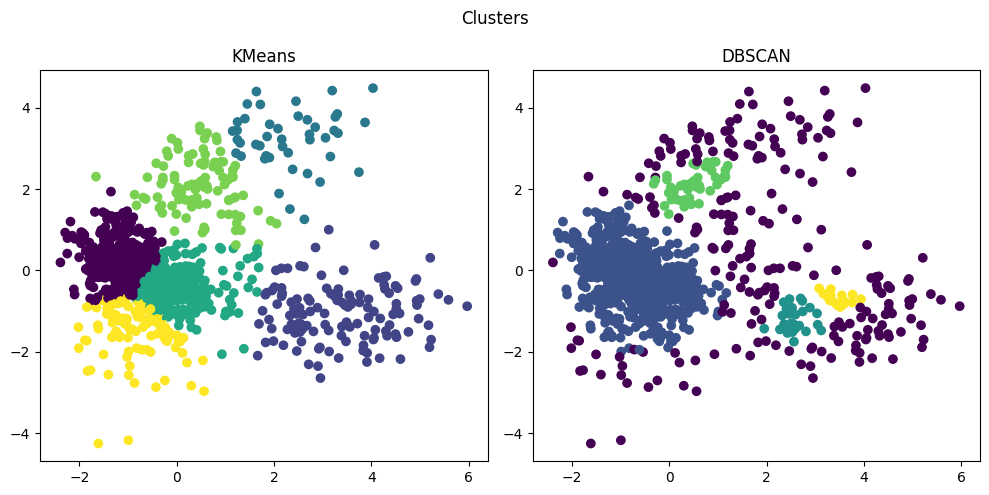

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))

ax1.set_title("KMeans")
ax1.scatter(reducedTest[:,0], reducedTest[:,1], c=kmeansClusters)

ax2.set_title("DBSCAN")  
ax2.scatter(reducedTest[:,0], reducedTest[:,1], c=dbscanClusters )

fig.suptitle("Clusters")
plt.tight_layout()
plt.show()